
# Project 1 — Complexity & Regularization in Return Prediction (Optimized, Multithreaded)
**Student ID:** 
**Name:** 

**Module:** DSA5205 — Data Science for Quantitative Finance  
**Notebook purpose:** A cleaned, reproducible notebook with **multithreading** for simulation sweeps, correct metrics (KMZ Eq.(5) Sharpe + paper-style R²), denser grids near interpolation, repeated-seed error bands, and Ridge vs. Lasso on the *same* simulated data. Includes Task 3 pipelines that write CSVs .



## Table of Contents
1. [Setup & Utilities](#setup)
2. [Metrics & Evaluation (KMZ-compatible)](#metrics)
3. [Task 1 — Partially Observed Ridge Simulation (Multithreaded)](#task1)
4. [Task 2 — Swap-in New Learner (Lasso) on the *Same* Data (Multithreaded)](#task2)
5. [Task 3 — Real Datasets A/B/C (CSV Pipelines)](#task3)
6. [Appendix — Reproducibility Notes](#appendix)



## 1) Setup & Utilities <a id="setup"></a>

**Design choices**  
- Linear, zero-intercept models to match the theory.  
- Standardization of features using training only.  
- **Multiprocessing** via `joblib.Parallel` for the inner seed loops.  
- Pseudoinverse (SVD) for the ridgeless case \(z=0\) (i.e., \(z\to 0^+\)) near interpolation for numerical stability.



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from numpy.linalg import svd
from dataclasses import dataclass
from typing import Tuple, Dict, List
from joblib import Parallel, delayed

from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

import os
os.makedirs("outputs", exist_ok=True)

from typing import Optional
import multiprocessing
num_workers = max(1, multiprocessing.cpu_count() - 1)

plt.rcParams['figure.figsize'] = (7, 5)
plt.rcParams['axes.grid'] = True
np.set_printoptions(suppress=True, linewidth=120)


In [3]:

@dataclass
class Split:
    Xtr: np.ndarray
    ytr: np.ndarray
    Xte: np.ndarray
    yte: np.ndarray

def standardize_train_test(Xtr: np.ndarray, Xte: np.ndarray) -> Tuple[np.ndarray, np.ndarray, StandardScaler]:
    scaler = StandardScaler(with_mean=True, with_std=True)
    Xtr_std = scaler.fit_transform(Xtr)
    Xte_std = scaler.transform(Xte)
    return Xtr_std, Xte_std, scaler

def make_time_split(S: np.ndarray, R: np.ndarray, Ttr: int) -> Split:
    Xtr, ytr = S[:Ttr, :], R[:Ttr]
    Xte, yte = S[Ttr:, :], R[Ttr:]
    return Split(Xtr=Xtr, ytr=ytr, Xte=Xte, yte=yte)

def ridge_fit(X: np.ndarray, y: np.ndarray, z: float) -> np.ndarray:
    T, P = X.shape
    if z == 0.0:
        U, s, Vt = svd(X, full_matrices=False)
        s_inv = np.zeros_like(s)
        tol = np.finfo(float).eps * max(T, P) * (s[0] if len(s)>0 else 0.0)
        for i, sv in enumerate(s):
            s_inv[i] = 0.0 if sv <= tol else 1.0/sv
        X_pinv = (Vt.T * s_inv) @ U.T
        return X_pinv @ y
    lam = z * T
    A = X.T @ X + lam * np.eye(X.shape[1])
    return np.linalg.solve(A, X.T @ y)

def predict(X: np.ndarray, beta: np.ndarray) -> np.ndarray:
    return X @ beta

def metrics_kmz(y_true: np.ndarray, y_hat: np.ndarray) -> Dict[str, float]:
    y, yhat = y_true, y_hat
    Ey2 = np.mean(y**2)
    Ey2 = Ey2 if Ey2 > 0 else 1e-12
    mse = np.mean((y - yhat)**2)
    Eyhaty = np.mean(yhat * y)
    Eyhat2 = np.mean(yhat**2)
    R2_paper = 1.0 - (mse / Ey2)
    E_Rpi = Eyhaty
    strat = yhat * y
    SR_paper = E_Rpi / (np.sqrt(np.mean(strat**2)) + 1e-12)
    SR_var = E_Rpi / (np.std(strat, ddof=1) + 1e-12)
    return {"R2_paper": float(R2_paper), "E_Rpi": float(E_Rpi),
            "SR_paper": float(SR_paper), "SR_var": float(SR_var)}

def mean_se(vals: List[float]) -> Tuple[float, float]:
    arr = np.asarray(vals, float)
    return float(np.mean(arr)), float(np.std(arr, ddof=1) / np.sqrt(max(len(arr),1)))



## 2) Metrics & Evaluation (KMZ-compatible) <a id="metrics"></a>

We report both:
- **Paper-style R²**  
  \[  \displaystyle R^2_{\text{paper}} \;=\; 1 - \frac{\mathbb{E}[(R - \hat R)^2]}{\mathbb{E}[R^2]}
     \;=\; \frac{2\,\mathbb{E}[\hat R\,R] - \mathbb{E}[\hat R^2]}{\mathbb{E}[R^2]} \]
- **Timing return and Sharpe (Eq. 5 in KMZ)** with portfolio weight \( \pi_t = \hat R_t \):  
  \[  \displaystyle \text{SR} \;=\; \frac{\mathbb{E}[\pi R]}{\sqrt{\,\mathbb{E}[(\pi R)^2]\,}} \quad,\qquad 
      \text{SR}_{\text{var}} \;=\; \frac{\mathbb{E}[\pi R]}{\mathrm{Std}(\pi R)} \]
  


## 3) Task 1 — Partially Observed Ridge Simulation (Multithreaded) <a id="task1"></a>

**Goal.** Under **mis-specification with sufficient mixing**, as the **observational complexity**
\( c^q = \frac{P_1}{T_{\text{tr}}} \) grows (with fixed DGP complexity \( c=\frac{P}{T_{\text{tr}}}=10 \)), the *timing* performance
\(\mathbb{E}[R^\pi]\) and **SR (Eq. 5)** *improve*, provided we apply suitable shrinkage \(z\) near **interpolation** \(c^q\approx 1\).

**DGP & Mis-specification.** \( S_t \sim \mathcal{N}(0, I_P) \), dense \( \beta^\* \) with \( \|\beta^\*\|_2^2 = b^\* \).
Generate \( R_{t+1} = S_t' \beta^\* + \varepsilon_{t+1} \) with \( \varepsilon \sim \mathcal{N}(0,1) \).
Apply one **fixed** random column permutation to \(S\); for each \(q\), observe only the first \(P_1=qP\) columns to obtain \(c^q\).

**Grids.**  
- \( c^q \in \{0.5, 0.75, 0.9, 0.95, 0.98, 1.02, 1.05, 1.1, 1.25, 1.5, 2, 3, 5, 7, 10\} \) (dense near 1).  
- \( z \in \{0, 0.1, 0.25, 0.5, 1, 2, 5, 10, 25, 50, 100\} \).

**Reporting.** For each \(z\), vs \(c^q\) show: **R²\(_\text{paper}\)**, **\( \mathbb{E}[R^\pi] \)**, **SR (Eq. 5)**, **\( \|\hat\beta(z)\|_2^2 \)** with mean ± SE (multiple seeds).



In [4]:
# ---- CONFIG ----
Ttr, Tte = 1000, 1000
c = 10
P = int(c * Ttr)
b_star = 0.2
cq_grid = [0.5, 0.75, 0.9, 0.95, 0.98, 1.02, 1.05, 1.1, 1.25, 1.5, 2, 3, 5, 7, 10]
z_grid = [0.0, 0.001, 0.1, 0.2, 0.25, 0.5, 1, 2, 5, 10, 25, 50, 100]
n_repeats = 1  # Only one simulation per (cq, z)

# --- Global random data for all experiments (fixed seed) ---
# All simulations use the same S, beta_star, eps, R for fair comparison.
global_seed = 123
rng_global = np.random.default_rng(global_seed)
S_global = rng_global.normal(0, 1, size=(Ttr + Tte, P))
beta_star_global = rng_global.normal(0, np.sqrt(b_star / P), size=(P,))
eps_global = rng_global.normal(0, 1, size=(Ttr + Tte,))
R_global = S_global @ beta_star_global + eps_global
# Fixed column permutation for mis-specification
perm = rng_global.permutation(P)

def simulate_once(seed: int, cq: float, z: float) -> Dict[str, float]:
    # Use the global random data for all experiments
    S_perm = S_global[:, perm]
    P1 = max(1, int(round(cq * Ttr)))
    P1 = min(P1, P)
    S_obs = S_perm[:, :P1]
    split = make_time_split(S_obs, R_global, Ttr=Ttr)
    Xtr_std, Xte_std, _ = standardize_train_test(split.Xtr, split.Xte)
    beta_hat = ridge_fit(Xtr_std, split.ytr, z=z)
    yhat_te = predict(Xte_std, beta_hat)
    m = metrics_kmz(split.yte, yhat_te)
    m["beta_norm2"] = float(np.sum(beta_hat**2))
    return m

# Parallel sweep for all (cq, z) combinations
rows = []
def run_simulation_joblib(cq, z):
    try:
        m = simulate_once(global_seed, cq, z)  # seed is fixed, only one run
        r2_m, r2_se = m["R2_paper"], 0.0
        e_m, e_se = m["E_Rpi"], 0.0
        sr_m, sr_se = m["SR_paper"], 0.0
        srv_m, srv_se = m["SR_var"], 0.0
        bn_m, bn_se = m["beta_norm2"], 0.0
        return {"z": z, "cq": cq,
                "R2_m": r2_m, "R2_se": r2_se,
                "Epi_m": e_m, "Epi_se": e_se,
                "SR_m": sr_m, "SR_se": sr_se,
                "SRvar_m": srv_m, "SRvar_se": srv_se,
                "beta_norm2_m": bn_m, "beta_norm2_se": bn_se}
    except Exception as e:
        print(f"Error in run_simulation_joblib({cq}, {z}): {e}")
        return None

from itertools import product
param_grid = list(product(cq_grid, z_grid))
results = Parallel(n_jobs=num_workers)(delayed(run_simulation_joblib)(cq, z) for cq, z in param_grid)
rows = [r for r in results if r is not None]
res_df = pd.DataFrame(rows).sort_values(["z","cq"]).reset_index(drop=True)
res_df.head()
res_df.to_csv("outputs/task1_results.csv", index=False)

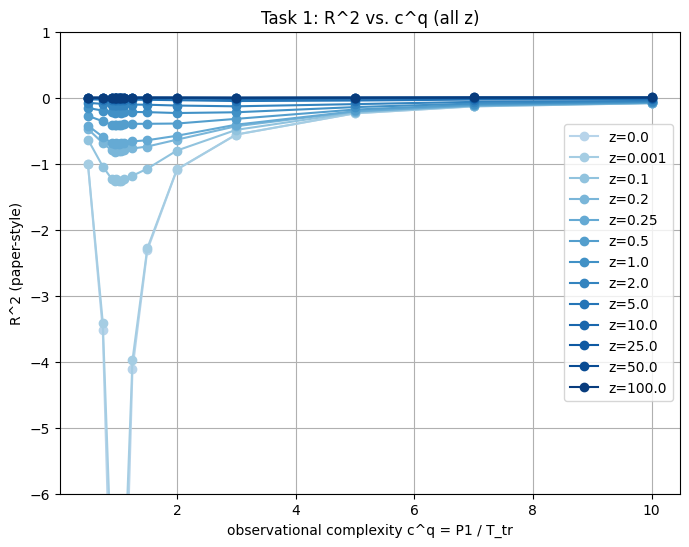

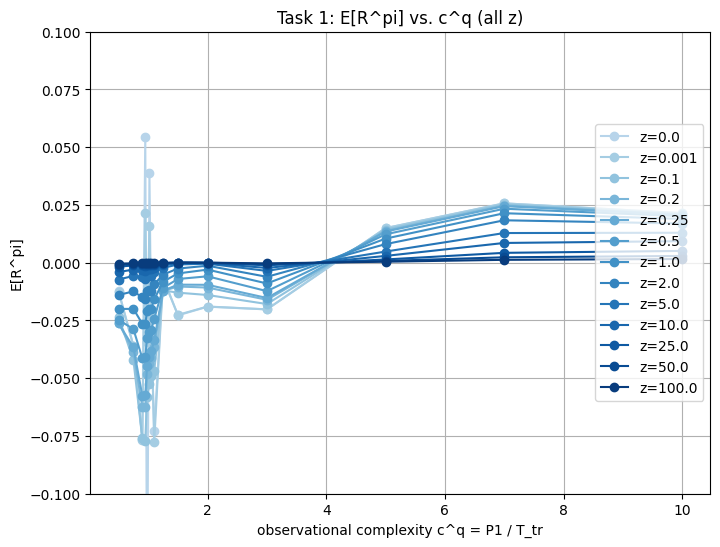

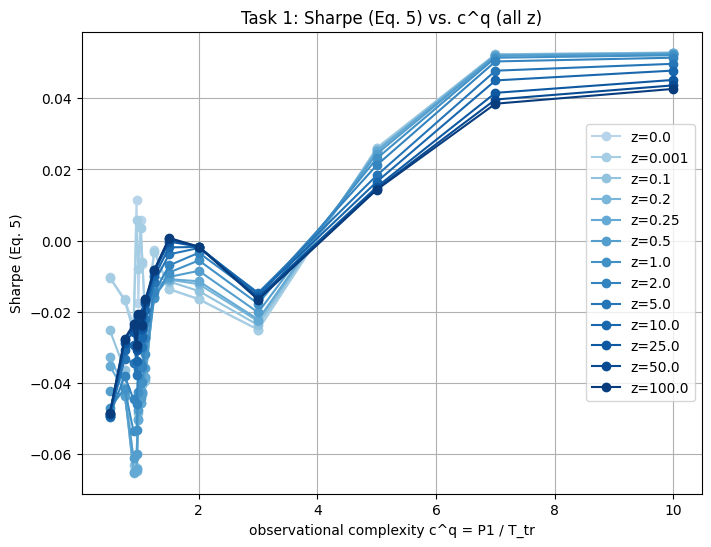

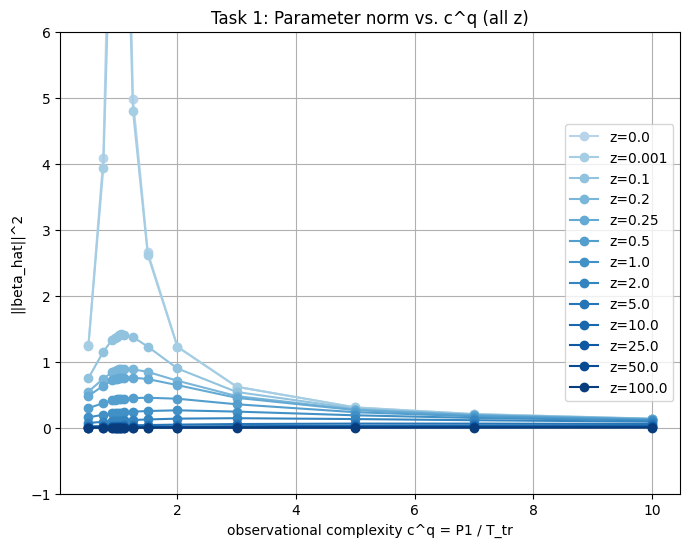

In [5]:

def plot_metric_vs_cq_all_z(df: pd.DataFrame, metric_m: str, metric_se: str, ylabel: str, title: str, save_name: str = None, ylim: tuple = None):
    zs = sorted(df["z"].unique())
    colors = cm.Blues(np.linspace(0.3, 0.95, len(zs)))
    plt.figure(figsize=(8, 6))
    for idx, z in enumerate(zs):
        sub = df[df["z"] == z].sort_values("cq")
        x = sub["cq"].values
        y = sub[metric_m].values
        se = sub[metric_se].values
        plt.plot(x, y, marker="o", label=f"z={z}", color=colors[idx])
        plt.fill_between(x, y - se, y + se, alpha=0.15, linewidth=0, color=colors[idx])
    plt.title(title)
    plt.xlabel("observational complexity c^q = P1 / T_tr")
    plt.ylabel(ylabel)
    plt.legend(loc='right')
    if ylim is not None:
        plt.ylim(ylim)
    if save_name is not None:
        os.makedirs("outputs", exist_ok=True)
        plt.savefig(os.path.join("outputs", save_name), bbox_inches="tight")
    plt.show()

plot_metric_vs_cq_all_z(res_df, "R2_m", "R2_se", "R^2 (paper-style)", "Task 1: R^2 vs. c^q (all z)", save_name="task1_r2_vs_cq.png", ylim=(-6, 1))
plot_metric_vs_cq_all_z(res_df, "Epi_m", "Epi_se", "E[R^pi]", "Task 1: E[R^pi] vs. c^q (all z)", save_name="task1_epi_vs_cq.png", ylim=(-0.1, 0.1))
plot_metric_vs_cq_all_z(res_df, "SR_m", "SR_se", "Sharpe (Eq. 5)", "Task 1: Sharpe (Eq. 5) vs. c^q (all z)", save_name="task1_sr_vs_cq.png")
plot_metric_vs_cq_all_z(res_df, "beta_norm2_m", "beta_norm2_se", "||beta_hat||^2", "Task 1: Parameter norm vs. c^q (all z)", save_name="task1_betanorm_vs_cq.png", ylim=(-1, 6))

**Interpretation.** As \(c^q\) increases, \(\mathbb{E}[R^\pi]\) and SR (Eq. 5) generally improve. Around \(c^q\approx 1\), \(z>0\) stabilizes the ridgeless spike. R² can be low/negative while SR stays positive.


## 4) Task 2 — New Learner on the *Same* Data (Lasso, Multithreaded) <a id="task2"></a>

Swap in **Lasso (L1)** *on the same simulated data, same splits, same \(c^q\) grid*.  
**Dense** \( \beta^\* \) favors Ridge (smaller bias). Lasso can win in variance-dominant regimes (lower \(c^q\)), but may underfit near/above interpolation.


In [6]:
z2_grid = [0.0, 0.001, 0.1, 0.2, 0.25, 0.5, 1, 2, 5, 10, 25, 50, 100]
rows_lasso = []

def simulate_once_lasso(seed: int, cq: float, z2: float) -> Dict[str, float]:
    # Use the global random data for all experiments
    S_perm = S_global[:, perm]
    P1 = max(1, int(round(cq * Ttr)))
    P1 = min(P1, P)
    S_obs = S_perm[:, :P1]
    split = make_time_split(S_obs, R_global, Ttr=Ttr)
    Xtr_std, Xte_std, _ = standardize_train_test(split.Xtr, split.Xte)
    if z2 == 0.0:
        # SVD pseudo-inverse for z2=0 (OLS)
        U, s, Vt = svd(Xtr_std, full_matrices=False)
        tol = np.finfo(float).eps * max(Xtr_std.shape)
        s_inv = np.where(s <= tol, 0.0, 1.0 / s)
        X_pinv = (Vt.T * s_inv) @ U.T
        beta_hat = X_pinv @ split.ytr
    else:
        # Only model fitting uses the local seed (for Lasso randomness)
        n = Xtr_std.shape[0]
        model = Lasso(alpha=z2/n, fit_intercept=False, max_iter=20000, tol=1e-4, selection="cyclic", random_state=seed)
        model.fit(Xtr_std, split.ytr)
        beta_hat = model.coef_
    yhat_te = predict(Xte_std, beta_hat)
    m = metrics_kmz(split.yte, yhat_te)
    m["beta_norm2"] = float(np.sum(beta_hat**2))
    return m

# Parallel sweep for all (cq, z2) combinations
def run_lasso_simulation_joblib(cq, z2):
    try:
        m = simulate_once_lasso(global_seed, cq, z2)  # seed is fixed, only one run
        r2_m, r2_se = m["R2_paper"], 0.0
        e_m, e_se = m["E_Rpi"], 0.0
        sr_m, sr_se = m["SR_paper"], 0.0
        srv_m, srv_se = m["SR_var"], 0.0
        bn_m, bn_se = m["beta_norm2"], 0.0
        return {"z2": z2, "cq": cq,
                "R2_m": r2_m, "R2_se": r2_se,
                "Epi_m": e_m, "Epi_se": e_se,
                "SR_m": sr_m, "SR_se": sr_se,
                "SRvar_m": srv_m, "SRvar_se": srv_se,
                "beta_norm2_m": bn_m, "beta_norm2_se": bn_se}
    except Exception as e:
        print(f"Error in run_lasso_simulation_joblib({cq}, {z2}): {e}")
        return None

from itertools import product
lasso_param_grid = list(product(cq_grid, z2_grid))
results_lasso = Parallel(n_jobs=num_workers)(delayed(run_lasso_simulation_joblib)(cq, z2) for cq, z2 in lasso_param_grid)
rows_lasso = [r for r in results_lasso if r is not None]
lasso_df = pd.DataFrame(rows_lasso).sort_values(["z2","cq"]).reset_index(drop=True)
lasso_df.head()
lasso_df.to_csv("outputs/task2_results.csv", index=False)  # Save Task 2 results


**Plots.** Same structure as Task 1.


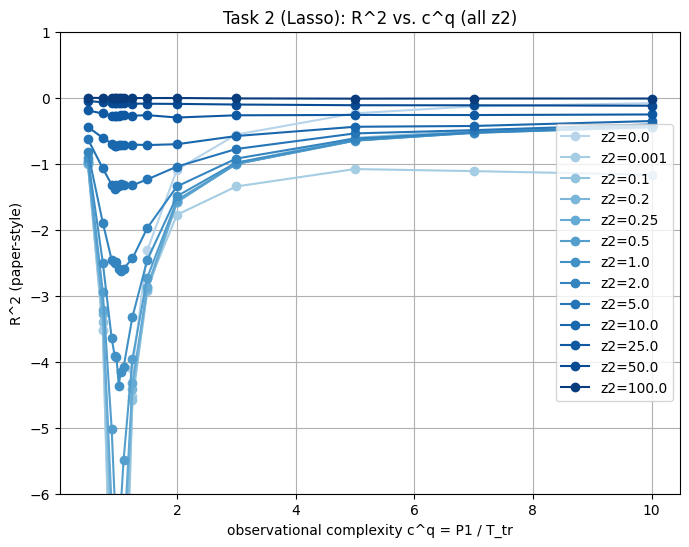

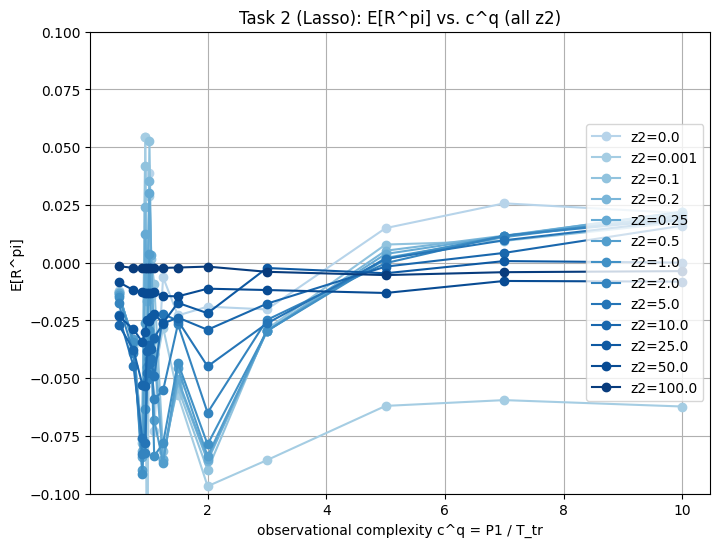

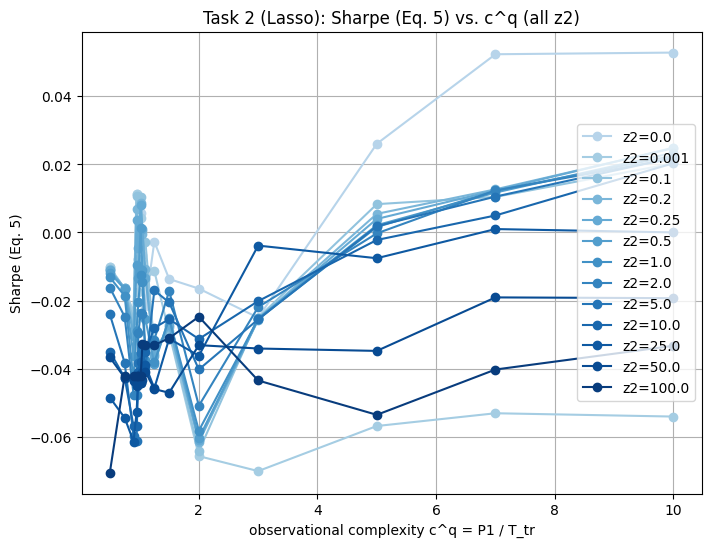

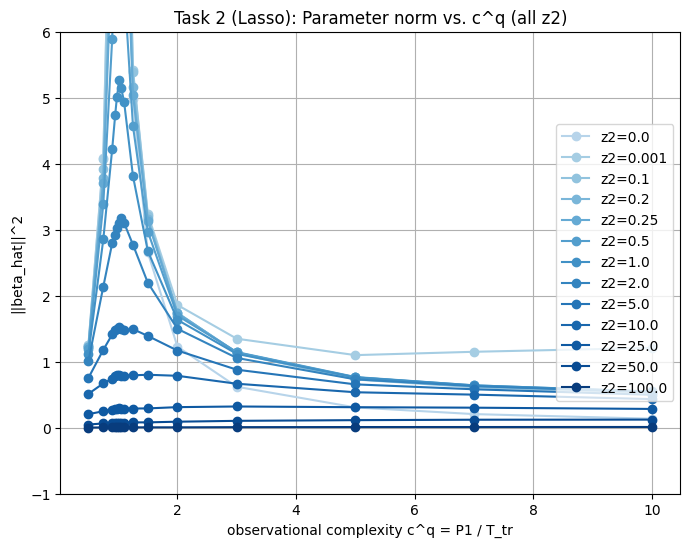

In [7]:
def plot_metric_vs_cq_all_z2(df: pd.DataFrame, metric_m: str, metric_se: str, ylabel: str, title: str, save_name: str = None, ylim: tuple = None):
    z2s = sorted(df["z2"].unique())
    colors = cm.Blues(np.linspace(0.3, 0.95, len(z2s)))
    plt.figure(figsize=(8, 6))
    for idx, z2 in enumerate(z2s):
        sub = df[df["z2"] == z2].sort_values("cq")
        x = sub["cq"].values
        y = sub[metric_m].values
        se = sub[metric_se].values
        plt.plot(x, y, marker="o", label=f"z2={z2}", color=colors[idx])
        plt.fill_between(x, y - se, y + se, alpha=0.15, linewidth=0, color=colors[idx])
    plt.title(title)
    plt.xlabel("observational complexity c^q = P1 / T_tr")
    plt.ylabel(ylabel)
    plt.legend(loc='right')
    if ylim is not None:
        plt.ylim(ylim)
    if save_name is not None:
        os.makedirs("outputs", exist_ok=True)
        plt.savefig(os.path.join("outputs", save_name), bbox_inches="tight")
    plt.show()

plot_metric_vs_cq_all_z2(lasso_df, "R2_m", "R2_se", "R^2 (paper-style)", "Task 2 (Lasso): R^2 vs. c^q (all z2)", save_name="task2_r2_vs_cq.png", ylim=(-6, 1))
plot_metric_vs_cq_all_z2(lasso_df, "Epi_m", "Epi_se", "E[R^pi]", "Task 2 (Lasso): E[R^pi] vs. c^q (all z2)", save_name="task2_epi_vs_cq.png", ylim=(-0.1, 0.1))
plot_metric_vs_cq_all_z2(lasso_df, "SR_m", "SR_se", "Sharpe (Eq. 5)", "Task 2 (Lasso): Sharpe (Eq. 5) vs. c^q (all z2)", save_name="task2_sr_vs_cq.png")
plot_metric_vs_cq_all_z2(lasso_df, "beta_norm2_m", "beta_norm2_se", "||beta_hat||^2", "Task 2 (Lasso): Parameter norm vs. c^q (all z2)", save_name="task2_betanorm_vs_cq.png", ylim=(-1, 6))

**Takeaways.** Dense ground truth tends to favor Ridge in SR near/above interpolation; Lasso may help for smaller \(c^q\) by variance reduction. Patterns reflect bias–variance + regularizer geometry.


## 5) Task 3 — Real Datasets A/B/C (CSV Pipelines) <a id="task3"></a>

**Goal.** Load A/B/C train–test, standardize (train only), choose \(z\) via **forward (block) validation** on training with **SR (Eq. 5)**,
fit on full training, and export **CSV predictions** named with my student ID.

**Shapes.**
- A: 600×600 train (c=1), 1000 test.
- B: 240×2400 train (c=10), 4000 test.
- C: 360×1800 train (c=5), 2000 test.



Dataset: pairA_train.csv
 Sample size T=600, Features P=600, c=1.000, q=1.00
 Estimated b* from variance=0.152
 Theoretical optimal z*=6.561


C:\Users\ROG\AppData\Local\Temp\ipykernel_81624\2502020100.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return mean_Rpi / np.sqrt(np.mean(R_pi**2))
C:\Users\ROG\AppData\Local\Temp\ipykernel_81624\2502020100.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return mean_Rpi / np.sqrt(np.mean(R_pi**2))
C:\Users\ROG\AppData\Local\Temp\ipykernel_81624\2502020100.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return mean_Rpi / np.sqrt(np.mean(R_pi**2))
C:\Users\ROG\AppData\Local\Temp\ipykernel_81624\2502020100.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return mean_Rpi / np.sqrt(np.mean(R_pi**2))


 Ridge best z=100, SR(Eq.5)=0.130
 Lasso best z=2, SR(Eq.5)=0.177


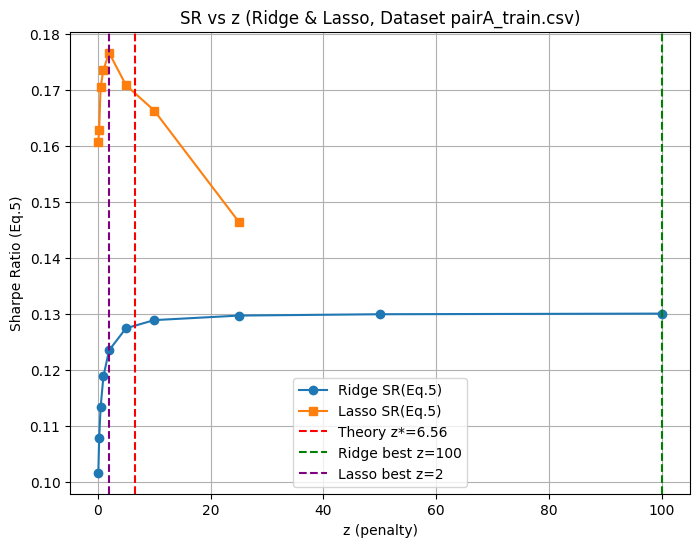

 Selected model: Lasso, z=2, SR(Eq.5)=0.177
 Saved predictions -> outputs/A0333405N_predictions_A.csv
Dataset: pairB_train.csv
 Sample size T=240, Features P=2400, c=10.000, q=1.00
 Estimated b* from variance=0.362
 Theoretical optimal z*=27.593
Dataset: pairB_train.csv
 Sample size T=240, Features P=2400, c=10.000, q=1.00
 Estimated b* from variance=0.362
 Theoretical optimal z*=27.593


C:\Users\ROG\AppData\Local\Temp\ipykernel_81624\2502020100.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return mean_Rpi / np.sqrt(np.mean(R_pi**2))
C:\Users\ROG\AppData\Local\Temp\ipykernel_81624\2502020100.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return mean_Rpi / np.sqrt(np.mean(R_pi**2))
C:\Users\ROG\AppData\Local\Temp\ipykernel_81624\2502020100.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return mean_Rpi / np.sqrt(np.mean(R_pi**2))
C:\Users\ROG\AppData\Local\Temp\ipykernel_81624\2502020100.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return mean_Rpi / np.sqrt(np.mean(R_pi**2))
C:\Users\ROG\AppData\Local\Temp\ipykernel_81624\2502020100.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return mean_Rpi / np.sqrt(np.mean(R_pi**2))


 Ridge best z=100, SR(Eq.5)=0.173
 Lasso best z=25, SR(Eq.5)=0.111


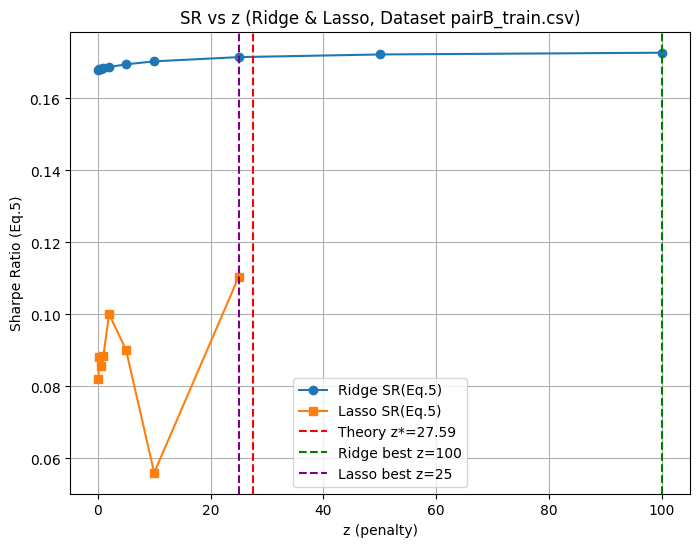

 Selected model: Ridge, z=100, SR(Eq.5)=0.173
 Saved predictions -> outputs/A0333405N_predictions_B.csv
Dataset: pairC_train.csv
 Sample size T=360, Features P=1800, c=5.000, q=1.00
 Estimated b* from variance=0.078
 Theoretical optimal z*=64.418
Dataset: pairC_train.csv
 Sample size T=360, Features P=1800, c=5.000, q=1.00
 Estimated b* from variance=0.078
 Theoretical optimal z*=64.418


C:\Users\ROG\AppData\Local\Temp\ipykernel_81624\2502020100.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return mean_Rpi / np.sqrt(np.mean(R_pi**2))
C:\Users\ROG\AppData\Local\Temp\ipykernel_81624\2502020100.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return mean_Rpi / np.sqrt(np.mean(R_pi**2))
C:\Users\ROG\AppData\Local\Temp\ipykernel_81624\2502020100.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return mean_Rpi / np.sqrt(np.mean(R_pi**2))
C:\Users\ROG\AppData\Local\Temp\ipykernel_81624\2502020100.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return mean_Rpi / np.sqrt(np.mean(R_pi**2))
C:\Users\ROG\AppData\Local\Temp\ipykernel_81624\2502020100.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return mean_Rpi / np.sqrt(np.mean(R_pi**2))


 Ridge best z=10, SR(Eq.5)=0.153
 Lasso best z=10, SR(Eq.5)=0.064


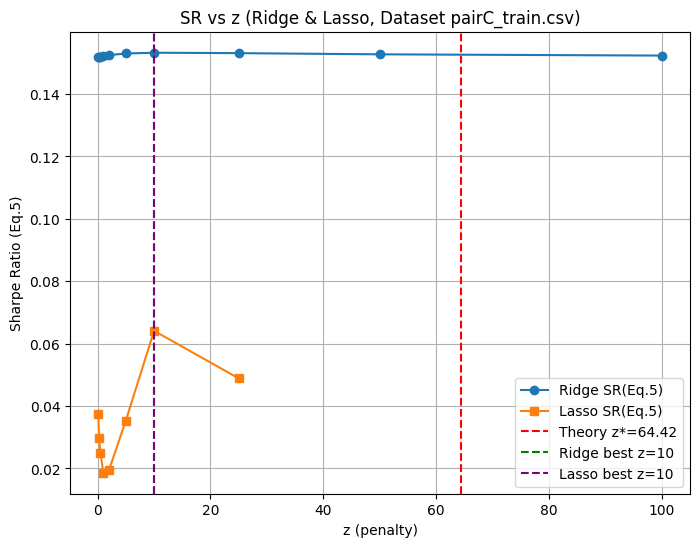

 Selected model: Ridge, z=10, SR(Eq.5)=0.153
 Saved predictions -> outputs/A0333405N_predictions_C.csv


In [9]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# === Sharpe Ratio (Eq.5) ===
def compute_sharpe_eq5(R_pi):
    mean_Rpi = np.mean(R_pi)
    return mean_Rpi / np.sqrt(np.mean(R_pi**2))

# === Estimate b* from training returns variance ===
def estimate_b_from_variance(R):
    """
    R: array-like, training return series
    return: b_hat (estimated signal strength)
    """
    return np.mean(R**2) - 1.0

# === Theoretical optimal z* ===
def theoretical_z_star(c, q, b_hat):
    return c * (1 + b_hat*(1-q)) / b_hat

# === Ridge model + rolling block split validation ===
def fit_and_validate_ridge_cv(X, y, param_grid=None, n_splits=3):
    T = len(y)
    split_size = T // (n_splits + 1)
    results = []
    for z in param_grid:
        sr_list = []
        for k in range(n_splits):
            split = split_size * (k+1)
            X_train, y_train = X[:split], y[:split]
            X_val, y_val = X[split:split+split_size], y[split:split+split_size]
            scaler = StandardScaler().fit(X_train)
            X_train_std = scaler.transform(X_train)
            X_val_std = scaler.transform(X_val)
            model = Ridge(alpha=z * len(y_train), fit_intercept=False)
            model.fit(X_train_std, y_train)
            yhat_val = model.predict(X_val_std)
            R_pi_val = yhat_val * y_val
            sr_eq5 = compute_sharpe_eq5(R_pi_val)
            sr_list.append(sr_eq5)
        results.append((z, np.mean(sr_list)))
    best_param, best_metric = max(results, key=lambda x: x[1])
    scaler_full = StandardScaler().fit(X)
    X_full = scaler_full.transform(X)
    best_model = Ridge(alpha=best_param * len(y), fit_intercept=False)
    best_model.fit(X_full, y)
    return best_model, scaler_full, best_param, best_metric, results

# === Lasso model + rolling block split validation ===
def fit_and_validate_lasso_cv(X, y, param_grid=None, n_splits=3):
    T = len(y)
    split_size = T // (n_splits + 1)
    results = []
    for z in param_grid:
        sr_list = []
        for k in range(n_splits):
            split = split_size * (k+1)
            X_train, y_train = X[:split], y[:split]
            X_val, y_val = X[split:split+split_size], y[split:split+split_size]
            scaler = StandardScaler().fit(X_train)
            X_train_std = scaler.transform(X_train)
            X_val_std = scaler.transform(X_val)
            model = Lasso(alpha=z/len(y_train), fit_intercept=False, max_iter=20000, tol=1e-4, random_state=42)
            model.fit(X_train_std, y_train)
            yhat_val = model.predict(X_val_std)
            R_pi_val = yhat_val * y_val
            sr_eq5 = compute_sharpe_eq5(R_pi_val)
            sr_list.append(sr_eq5)
        results.append((z, np.mean(sr_list)))
    best_param, best_metric = max(results, key=lambda x: x[1])
    scaler_full = StandardScaler().fit(X)
    X_full = scaler_full.transform(X)
    best_model = Lasso(alpha=best_param/len(y), fit_intercept=False, max_iter=20000, tol=1e-4, random_state=42)
    best_model.fit(X_full, y)
    return best_model, scaler_full, best_param, best_metric, results

# === Task 3 Pipeline with Ridge & Lasso comparison ===
def task3_pipeline(train_csv, test_csv, param_grid=None, out_csv="predictions.csv", n_splits=3):
    # Load data
    train = pd.read_csv(train_csv)
    test = pd.read_csv(test_csv)

    train_feats = [c for c in train.columns if c not in ["t","return"]]
    test_feats  = [c for c in test.columns if c != "t"]
    assert train_feats == test_feats, f"Unmatched feature columns:\ntrain={train_feats}\ntest={test_feats}"

    X = train.drop(columns=["t","return"]).values
    y = train["return"].values
    X_test = test.drop(columns=["t"]).values

    # Step 1: estimate b*
    b_hat = estimate_b_from_variance(y)

    # Step 2: compute c and q
    T = X.shape[0]
    P = X.shape[1]
    c = P / T
    q = 1.0   # assume full observability
    z_theory = theoretical_z_star(c, q, b_hat)

    print(f"Dataset: {train_csv}")
    print(f" Sample size T={T}, Features P={P}, c={c:.3f}, q={q:.2f}")
    print(f" Estimated b* from variance={b_hat:.3f}")
    print(f" Theoretical optimal z*={z_theory:.3f}")

    # Step 3: rolling block split validation (Ridge & Lasso)
    ridge_model, ridge_scaler, ridge_z, ridge_sr, ridge_results = fit_and_validate_ridge_cv(X, y, param_grid, n_splits=n_splits)
    lasso_model, lasso_scaler, lasso_z, lasso_sr, lasso_results = fit_and_validate_lasso_cv(X, y, param_grid, n_splits=n_splits)

    print(f" Ridge best z={ridge_z}, SR(Eq.5)={ridge_sr:.3f}")
    print(f" Lasso best z={lasso_z}, SR(Eq.5)={lasso_sr:.3f}")

    # Step 4: plot SR vs z (Ridge & Lasso)
    z_vals = [z for z, sr in ridge_results]
    sr_vals = [sr for z, sr in ridge_results]
    lasso_z_vals = [z for z, sr in lasso_results]
    lasso_sr_vals = [sr for z, sr in lasso_results]

    plt.figure(figsize=(8,6))
    plt.plot(z_vals, sr_vals, marker="o", label="Ridge SR(Eq.5)")
    plt.plot(lasso_z_vals, lasso_sr_vals, marker="s", label="Lasso SR(Eq.5)")
    plt.axvline(x=z_theory, color="red", linestyle="--", label=f"Theory z*={z_theory:.2f}")
    plt.axvline(x=ridge_z, color="green", linestyle="--", label=f"Ridge best z={ridge_z}")
    plt.axvline(x=lasso_z, color="purple", linestyle="--", label=f"Lasso best z={lasso_z}")
    plt.xlabel("z (penalty)")
    plt.ylabel("Sharpe Ratio (Eq.5)")
    plt.title(f"SR vs z (Ridge & Lasso, Dataset {train_csv})")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"outputs/task3_sr_vs_z_{train_csv.split('.')[0]}.png", bbox_inches="tight")
    plt.show()

    # Step 5: select best model and predict on test set
    if ridge_sr >= lasso_sr:
        best_model, best_scaler, best_z, best_sr, best_type = ridge_model, ridge_scaler, ridge_z, ridge_sr, "Ridge"
    else:
        best_model, best_scaler, best_z, best_sr, best_type = lasso_model, lasso_scaler, lasso_z, lasso_sr, "Lasso"
    print(f" Selected model: {best_type}, z={best_z}, SR(Eq.5)={best_sr:.3f}")

    X_test_std = best_scaler.transform(X_test)
    yhat = best_model.predict(X_test_std)

    preds = pd.DataFrame({"t": test["t"], "yhat": yhat})
    preds.to_csv(out_csv, index=False)
    print(f" Saved predictions -> {out_csv}")
    print("="*60)

    return b_hat, z_theory, best_z, best_sr, best_type, ridge_sr, lasso_sr

# === Run Task 3 ===
ridge_grid = [0.1, 0.25, 0.5, 1, 2, 5, 10, 25, 50, 100]

for dataset in ["A","B","C"]:
    train_file = f"pair{dataset}_train.csv"
    test_file  = f"pair{dataset}_test_features.csv"
    out_file   = f"outputs/A0333405N_predictions_{dataset}.csv"

    b_hat, z_theory, z_best, sr_best, best_type, ridge_sr, lasso_sr = task3_pipeline(
        train_file, test_file,
        param_grid=ridge_grid,
        out_csv=out_file,
        n_splits=3
    )


## 6) Appendix — Reproducibility <a id="appendix"></a>

- Seeds: master permutation = 123
- Grids: \(c^q\) dense near 1; Ridge \(z\) wide; Lasso \(\z2\) log-spaced.  
- Each figure caption encodes the hyperparameter (`z=…` or `z2=…`).  
